<h2> Generating Deforestation Time Series </h2>

This notebook will outline how annual forest cover loss time series were acquired for this project. The data was retrieved from the Global Forest Change 2001 - 2021 dataset generated by Hansen et al. at a 30 meter spatial resolution. 

First, we import relevant libraries for this notebook. Note that operations on geometric objects are conducted using shapely. 

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from SyntheticControlMethods import Synth
from PIL import Image

<h3> Guyana </h3>

As a preliminary example, we will attempt to plot the time-series of forest cover for Guyana, our first target country. As this has previously been done in Roopsind et al. 2019, we will be able to compare our results to ensure that the process is successful. 

In [6]:
country = 'Guyana'
canopy_threshold = 30

Here, we import the relevant tiles for Guyana, which were downloaded from the Gloabl Forest Change dataset. The process to acquire these on a country basis can be a little tedious as the correct coordinates and therefore tiles will first need to be identified. For this project, the tiles were stored on Sherwood, a computing facility available under the Cambridge Center for Carbon Credits. Please modify the paths to where the appropriate tiles are located if running this locally.

In [4]:
im10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_060W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")

In [19]:
ar10_60 = np.array(im10_60)
ar10_70 = np.array(im10_70)

In [7]:
boundaries = gpd.read_file("../data/World_Countries__Generalized_.shp")
country_shp = boundaries[boundaries['COUNTRY'] == country].geometry

<AxesSubplot: >

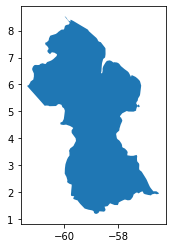

In [7]:
country_shp.plot()

First, we will resize the original grid, which is 40,000 pixels per side (approximately 30m x 30m), to 4,000 pixels per side (therefore, approximately 300m x 300m). This becomes much more manageable computationally, as the number of pixels per tile is reduced by a factor of 100. Note that the functions developed here were later compiled in time_series_generation.py located in the scripts folder. 

In [8]:
def rebin(a, shape):
    '''
    Resizes a numpy array to the desired shape.
    '''
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [9]:
def point_within_country(row, country_shp):
    '''
    Checks if the entered latitude and longitude are within the country of
    interest.
    '''
    point = Point(row['lon'], row['lat'])
    return country_shp.contains(point)


def sum_tile(tile, country_shp, topleftlat, topleftlon, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels within the tile provided.

    Forest pixels are considered as those where canopy cover is greater than 
    or equal to the provided threshold. Typically, this is 30%.
    '''
    n = len(tile)

    tile_df = pd.DataFrame({'x': n * [x for x in range(n)],
                            'y': np.array([n * [y] for y in range(n)]).flatten()})

    tile_df['lat'] = topleftlat - (tile_df['y']/n) * 10
    tile_df['lon'] = topleftlon + (tile_df['x']/n) * 10

    tile_df['cover'] = tile.flatten()

    tile_df['country'] = tile_df.apply(
        point_within_country, axis=1, args=(country_shp,))

    forest_pixels = len(tile_df[(tile_df["country"] == True) & (
        tile_df["cover"] >= canopy_threshold)])
    country_pixels = len(tile_df[tile_df["country"] == True])

    return [forest_pixels, country_pixels, tile_df]

In [10]:
ar10_60_4k = rebin(ar10_60, [4000, 4000])
ar10_70_4k = rebin(ar10_70, [4000, 4000])

In [11]:
def sum_across_tiles(tiles, country_shp, topleftlats, topleftlons, canopy_threshold):
    '''
    Calculates total forest pixels and country pixels contained within the
    provided tiles. It is important to ensure that all tiles spanning the 
    country are provided.
    '''
    forest_total = 0
    country_total = 0
    tile_dfs = []
    for i, tile in enumerate(tiles):
        summary = sum_tile(tile, country_shp,
                           topleftlats[i], topleftlons[i], canopy_threshold)
        forest_total += summary[0]
        country_total += summary[1]
        tile_dfs.append(summary[2])
    return [forest_total, country_total, tile_dfs]

In [12]:
country_summed = sum_across_tiles([ar10_60_4k, ar10_70_4k], country_shp, [10, 10], [-60, -70], canopy_threshold)

In [21]:
country_summed

[2508151,
 2748015,
 [             x     y      lat      lon  cover  country
  0            0     0  10.0000 -60.0000   0.00    False
  1            1     0  10.0000 -59.9975   0.00    False
  2            2     0  10.0000 -59.9950   0.00    False
  3            3     0  10.0000 -59.9925   0.00    False
  4            4     0  10.0000 -59.9900   0.00    False
  ...        ...   ...      ...      ...    ...      ...
  15999995  3995  3999   0.0025 -50.0125   0.00    False
  15999996  3996  3999   0.0025 -50.0100   0.00    False
  15999997  3997  3999   0.0025 -50.0075   0.00    False
  15999998  3998  3999   0.0025 -50.0050   5.76    False
  15999999  3999  3999   0.0025 -50.0025   0.00    False
  
  [16000000 rows x 6 columns],
               x     y      lat      lon  cover  country
  0            0     0  10.0000 -70.0000  32.30    False
  1            1     0  10.0000 -69.9975  43.68    False
  2            2     0  10.0000 -69.9950  20.49    False
  3            3     0  10.0000 -6

<h3> Forest Cover Change Over Time </h3>

The above section has explored how to obtain initial forest cover in the year 2000 for a given country, which will be output by the function sum_across_tiles. Now, we will see how to use the forest cover loss layer provided in Hansen to obtain a time series of forest cover trajectory through to 2021. 

In [22]:
loss10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_060W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")

In [23]:
loss10_60 = np.array(loss10_60)
loss10_70 = np.array(loss10_70)

An attempt to resize the loss tiles into 4,000 by 4,000 grids was made similarly to the cover arrays. However, as can be seen below, taking the mean significantly changes the distribution of loss years, leading to meaningless results. Even after replacing 0 values (indicating no loss) with NaNs, the distribution is very much altered. 

In [60]:
loss10_60_4k = rebin(loss10_60, [4000, 4000])
loss10_70_4k = rebin(loss10_70, [4000, 4000])

(array([ 870289.,  753990.,  816425.,  838676.,  995756., 1223628.,
        1223271., 1785863., 1697814., 1940159.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

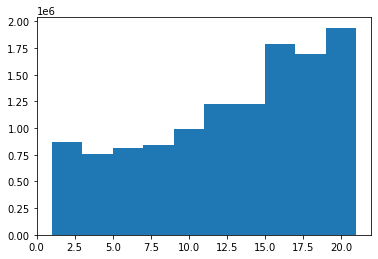

In [106]:
plt.hist(loss10_60.flatten(), range=[1,21])

(array([144931.,  65361.,  37783.,  23169.,  14182.,   9149.,   6017.,
          3920.,   1758.,    861.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

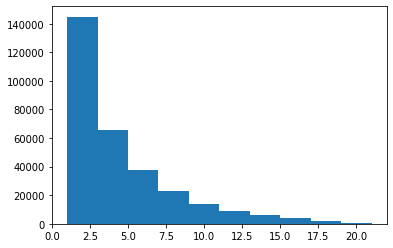

In [111]:
plt.hist(loss10_60_4k.flatten(), range = [1,21])

In [138]:
def rebin_loss(a, shape):
    '''
    Resizes a numpy array to the desired shape, accounting for NaNs. 
    '''
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return np.nanmean(np.nanmean(a.reshape(sh), -1), 1)

In [143]:
loss10_60_nan = rebin_loss(loss10_60_pn, [4000, 4000])

/tmp/ipykernel_197608/2346147602.py:3: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(a.reshape(sh), -1), 1)


(array([ 51891.,  53054.,  57812.,  74640.,  96926., 206553., 102707.,
         91575.,  70908.,  65422.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

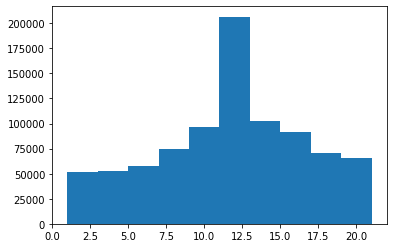

In [150]:
plt.hist(loss10_60_nan.flatten(), range=[1,21])

The new approach to quantifying loss involved obtaining all loss values contained within the original 40,000 by 40,000 grid which were placed within the country of interest (as per the 4,000 by 4,000 grid). This retains the general distribution of loss years.

(array([166495., 131953., 130006., 156990., 190748., 232103., 212879.,
        438202., 333041., 492761.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

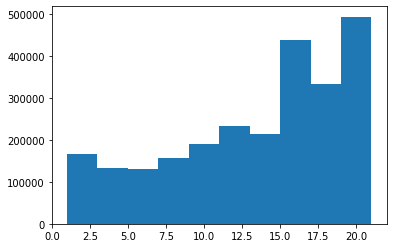

In [213]:
plt.hist(all, range=[1,21])

We now proceed to generating the trajectory by using the initial cover in the year 2000 and the loss in each year through to 2021. Below, we develop a function to do this and attempt to obtain the trajectory for Guyana. 

In [32]:
def cover_trajectory(forest_total, tile_dfs, loss_tiles):
    '''
    Given outputs of sum_across_tiles as well as loss_tiles, this provides the
    full annual forest loss trajectory for the dataset. 

    This function currently assumes that forest loss was calculated at the
    full 40,000 x 40,000 grid level, while the initial forest cover was only
    calculated at a 4,000 x 4,000 grid level. This would result in a 100 factor
    difference within the values obtained, which is accounted for here. 
    '''

    trajectory = dict()

    for i, df in enumerate(tile_dfs):

        df = df[df['country'] == True]
        df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
                      for (x, y) in zip(df['x'], df['y'])]

        unique, counts = np.unique(df['loss'].explode(), return_counts=True)
        tile_trajectory = dict(zip(unique, counts))
        trajectory = {key: trajectory.get(key, 0) + tile_trajectory.get(key, 0)
                      for key in set(trajectory) | set(tile_trajectory)}

    annual_loss = []

    for year in range(1, max(trajectory.keys()) + 1):
        # This is a percentage without multiplying by 100, since loss is at a 100 times higher resolution
        cover_loss = trajectory[year]/forest_total
        forest_total -= trajectory[year]/100
        annual_loss.append(cover_loss)

    return annual_loss

In [34]:
guyana_loss = cover_trajectory(country_summed[0], country_summed[2], [loss10_60, loss10_70])

/tmp/ipykernel_230519/3208897696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/tmp/ipykernel_230519/3208897696.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


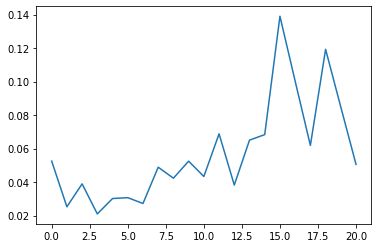

In [36]:
plt.plot(guyana_loss)

Based on Roopsind et al., this is exactly as we would expect the trajectory to look. Finally, we can append this to a .csv file where we intend to compile these time series for eventual use in our synthetic control.

In [40]:
guyana = pd.DataFrame({'Country': country, 'Year': [x for x in range(2001, 2022)], 'Annual Tree Cover Loss': guyana_loss})

In [42]:
guyana.to_csv('../data/main.csv')

<h3> Testing Script </h3>

The entire process outlined above for generation of forest trajectories was compiled into time_series_generation.py, with a one-shot function generate_trajectory which can carry out the whole process. We test this below to ensure that the same results are obatined. 

In [3]:
import os
os.chdir('/home/og309/jurisdictional-interventions/scripts/')

In [4]:
from time_series_generation import generate_trajectory

In [3]:
im10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_060W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")
loss10_60 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_060W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")

In [7]:
generate_trajectory('Guyana', [im10_60, im10_70], [loss10_60, loss10_70], [10, 10], [-60, -70], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss
0,Guyana,2001,0.052502
1,Guyana,2002,0.025239
2,Guyana,2003,0.038911
3,Guyana,2004,0.020974
4,Guyana,2005,0.030157
5,Guyana,2006,0.030679
6,Guyana,2007,0.027203
7,Guyana,2008,0.048867
8,Guyana,2009,0.042304
9,Guyana,2010,0.052459


Next, we continue to generate such time series for other countries that we require, namely the 6 countries in Roopsind et al.'s donor pool: Suriname, Gabon, Peru, Colombia, Congo, and Congo DRC.

In [7]:
generate_trajectory('Suriname', [im10_60], [loss10_60], [10], [-60], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss
0,Suriname,2001,0.026131
1,Suriname,2002,0.026670
2,Suriname,2003,0.031882
3,Suriname,2004,0.037160
4,Suriname,2005,0.024730
5,Suriname,2006,0.023909
6,Suriname,2007,0.025118
7,Suriname,2008,0.052936
8,Suriname,2009,0.052763
9,Suriname,2010,0.049889


In [3]:
im00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_000E.tif")
im00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_010E.tif")
im10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_000E.tif")
im10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_010E.tif")
loss00_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_000E.tif")
loss00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_010E.tif")
loss10_00 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_000E.tif")
loss10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_010E.tif")

In [12]:
generate_trajectory('Gabon', [im00_00, im00_10, im10_00, im10_10], [loss00_00, loss00_10, loss10_00, loss10_10],
                    [0, 0, 10, 10], [0, 10, 0, 10], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWith

,Country,Year,Annual Tree Cover Loss
0,Gabon,2001,0.060610
1,Gabon,2002,0.056369
2,Gabon,2003,0.067562
3,Gabon,2004,0.040849
4,Gabon,2005,0.071947
5,Gabon,2006,0.079807
6,Gabon,2007,0.068440
7,Gabon,2008,0.070547
8,Gabon,2009,0.074661
9,Gabon,2010,0.043449


In [26]:
generate_trajectory('Congo', [im00_10, im10_10], [loss00_10, loss10_10],
                    [0, 10], [10, 10], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()


,Country,Year,Annual Tree Cover Loss
0,Congo,2001,0.101083
1,Congo,2002,0.090643
2,Congo,2003,0.070684
3,Congo,2004,0.052009
4,Congo,2005,0.071072
5,Congo,2006,0.084443
6,Congo,2007,0.113510
7,Congo,2008,0.068887
8,Congo,2009,0.075784
9,Congo,2010,0.176008


In [7]:
im00_90 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_090W.tif")
im00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_080W.tif")
im00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_070W.tif")
im10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_080W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_070W.tif")
loss00_90 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_090W.tif")
loss00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_080W.tif")
loss00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif")
loss10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_080W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_070W.tif")

In [10]:
generate_trajectory('Peru', [im00_90, im00_80, im00_70, im10_80, im10_70], [loss00_90, loss00_80, loss00_70, loss10_80, loss10_70],
                    [0, 0, 0, -10, -10], [-90, -80, -70, -80, -70], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWith

,Country,Year,Annual Tree Cover Loss
0,Peru,2001,0.110769
1,Peru,2002,0.103705
2,Peru,2003,0.095383
3,Peru,2004,0.130534
4,Peru,2005,0.210203
5,Peru,2006,0.114907
6,Peru,2007,0.149145
7,Peru,2008,0.163748
8,Peru,2009,0.230665
9,Peru,2010,0.184993


In [5]:
im00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_080W.tif")
im00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_070W.tif")
im10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_080W.tif")
im10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_070W.tif")
im20_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_20N_080W.tif")
loss00_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_080W.tif")
loss00_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_070W.tif")
loss10_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_080W.tif")
loss10_70 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_070W.tif")
loss20_80 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_20N_080W.tif")

In [6]:
generate_trajectory('Colombia', [im00_80, im00_70, im10_80, im10_70, im20_80], [loss00_80, loss00_70, loss10_80, loss10_70, loss20_80],
                    [0, 0, 10, 10, 20], [-80, -70, -80, -70, -80], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWith

,Country,Year,Annual Tree Cover Loss
0,Colombia,2001,0.276901
1,Colombia,2002,0.219304
2,Colombia,2003,0.149171
3,Colombia,2004,0.307252
4,Colombia,2005,0.229117
5,Colombia,2006,0.231625
6,Colombia,2007,0.328282
7,Colombia,2008,0.283810
8,Colombia,2009,0.292893
9,Colombia,2010,0.242195


In [5]:
im10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_010E.tif")
im00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_010E.tif")
im10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_020E.tif")
im00_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_020E.tif")
imm10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10S_020E.tif")
im10_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_10N_030E.tif")
im00_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_treecover2000_00N_030E.tif")
loss10_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_010E.tif")
loss00_10 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_010E.tif")
loss10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_020E.tif")
loss00_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_020E.tif")
lossm10_20 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10S_020E.tif")
loss10_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_10N_030E.tif")
loss00_30 = Image.open("/maps-priv/maps/og309/Hansen_GFC-2021-v1.9_lossyear_00N_030E.tif")

In [10]:
generate_trajectory('Congo DRC', [im10_10, im00_10, im10_20, im00_20, imm10_20, im10_30, im00_30], [loss10_10, loss00_10, loss10_20, loss00_20, lossm10_20, loss10_30, loss00_30],
                    [10, 0, 10, 0, -10, 10, 0], [10, 10, 20, 20, 20, 30, 30], 30)

/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss'] = [loss_tiles[i][(y * 10):(y * 10 + 10), (x * 10):(x * 10 + 10)].flatten()
/home/og309/jurisdictional-interventions/scripts/time_series_generation.py:90: SettingWith

Finally, plotting these out, we can once again confirm that the trajectories match past studies and look as expected. These will be used in our synthetic control - but first, we will need to bring in the required covariates, which can be seen in covariate_integration.ipynb. 

/tmp/ipykernel_1793426/330569867.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, grp in main.groupby(['Country']):


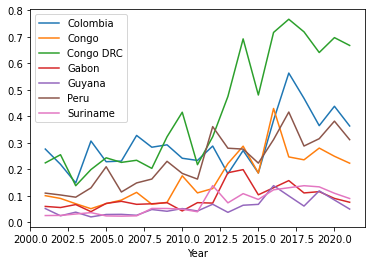

In [6]:
main = pd.read_csv('../data/main.csv')

fig, ax = plt.subplots()
for key, grp in main.groupby(['Country']):
    ax = grp.plot(ax=ax, kind='line', x='Year', y='Annual Tree Cover Loss', label=key, figsize=(12,6), xticks = [2000 + x for x in range(1,22)])